# Entity Embedding - Working Example " House Prices"

**The purpose of this notebook is to demonstrate  the practical implementation of the so-called Entity Embedding  for Encoding Categorical Features for Training a Neural Network.**

## Loading Libraries

In [3]:
import os 
import matplotlib.pylab as plt
import pandas as pd

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

##  The Ames Iowa Housing Data. 

In [2]:
url = 'http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls'
# Load the file into a Pandas DataFrame
data_df = pd.read_excel(url)
print('DataFrame size:', data_df.shape)

DataFrame size: (2930, 82)


In [4]:
data_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,...,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,...,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,...,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,...,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,...,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,...,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Sub-Feature Space

In [5]:
# For same of demonstration, the following features are selected. 
features = ['Neighborhood','Bldg Type','Year Built','Roof Matl','Sale Condition','Sale Type','House Style','Gr Liv Area']

# The aim is to predcit sale prices.
target = ['SalePrice']
data_df=data_df[features + target]
data_df['Year Built']= data_df['Year Built'].astype('object')

## Data Preparation



### *  ** Train/Val/Test Split**

In [6]:
X_train, y_train = data_df.iloc[:2000][features], data_df.iloc[:2000][target]
X_val, y_val = data_df.iloc[2000:2500][features], data_df.iloc[2000:2500][target]
X_test = data_df.iloc[2500:][features]

### *  ** Data Transformations**

In [7]:
scalar=StandardScaler()
scalar.fit(X_train['Gr Liv Area'].values.reshape(-1, 1))
X_train['Gr Liv Area']=scalar.transform(X_train['Gr Liv Area'].values.reshape(-1, 1)) 
X_val['Gr Liv Area']=scalar.transform(X_val['Gr Liv Area'].values.reshape(-1, 1)) 

scalar.fit(y_train)
y_train=scalar.transform(y_train)
y_val=scalar.transform(y_val)

### *  ** Check for Mising Values**

In [8]:
missing_df = data_df[features + target].isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(data_df[features + target].shape[0]-missing_df['missing values'])/data_df[features + target].shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Neighborhood,0,100.0
1,Bldg Type,0,100.0
2,Year Built,0,100.0
3,Roof Matl,0,100.0
4,Sale Condition,0,100.0
5,Sale Type,0,100.0
6,House Style,0,100.0
7,Gr Liv Area,0,100.0
8,SalePrice,0,100.0


## *  **  Categorical Features Embedding Preparation**

### *  ** Categorical Features and  Cardinality**

In [9]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

for i in embed_cols:
    print(i,data_df[i].nunique())

Neighborhood 28
Bldg Type 5
Year Built 118
Roof Matl 8
Sale Condition 6
Sale Type 10
House Style 8


### *  ** Categorical Features To List Format**
One need to convert data to list format to match the network structure. 

The following function takes the list of categorical features, and prepare such lists for the NN input.

In [10]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test 

In [11]:
X_train.head()

,Neighborhood,Bldg Type,Year Built,Roof Matl,Sale Condition,Sale Type,House Style,Gr Liv Area
0,NAmes,1Fam,1960,CompShg,Normal,WD,1Story,0.315074
1,NAmes,1Fam,1961,CompShg,Normal,WD,1Story,-1.224202
2,NAmes,1Fam,1958,CompShg,Normal,WD,1Story,-0.347220
3,NAmes,1Fam,1968,CompShg,Normal,WD,1Story,1.234589
4,Gilbert,1Fam,1997,CompShg,Normal,WD,2Story,0.260389


### *  ** Embedding Dimension - Hyperparamter**
The choice of embedding dimension is optional, essentially it is a hyperparamter that one need to choose beforehand and investigate. One rule of thumb is to choose half of the cardinality of the categorical feature if that is is up to 50 in length. 


In [12]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorica Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorica Variable: Neighborhood Unique Categories: 26 Embedding Size: 13
Categorica Variable: Bldg Type Unique Categories: 5 Embedding Size: 3
Categorica Variable: Year Built Unique Categories: 116 Embedding Size: 50
Categorica Variable: Roof Matl Unique Categories: 7 Embedding Size: 4
Categorica Variable: Sale Condition Unique Categories: 6 Embedding Size: 3
Categorica Variable: Sale Type Unique Categories: 9 Embedding Size: 5
Categorica Variable: House Style Unique Categories: 8 Embedding Size: 4


### *  ** Proper Naming of Categorical Features for Labelling NN Layers**

In [14]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_Neighborhood
Input_BldgType
Input_YearBuilt
Input_RoofMatl
Input_SaleCondition
Input_SaleType
Input_HouseStyle


## *  ** Build Neural Network**




### *  ** Putting it Altogether**
Here we basically make the embeding layers one at a time and append, and at the end we concatenate it together with the numerical features.


In [15]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])

### *  ** The Network Architecture**


In [16]:
import pydot_ng as pydot

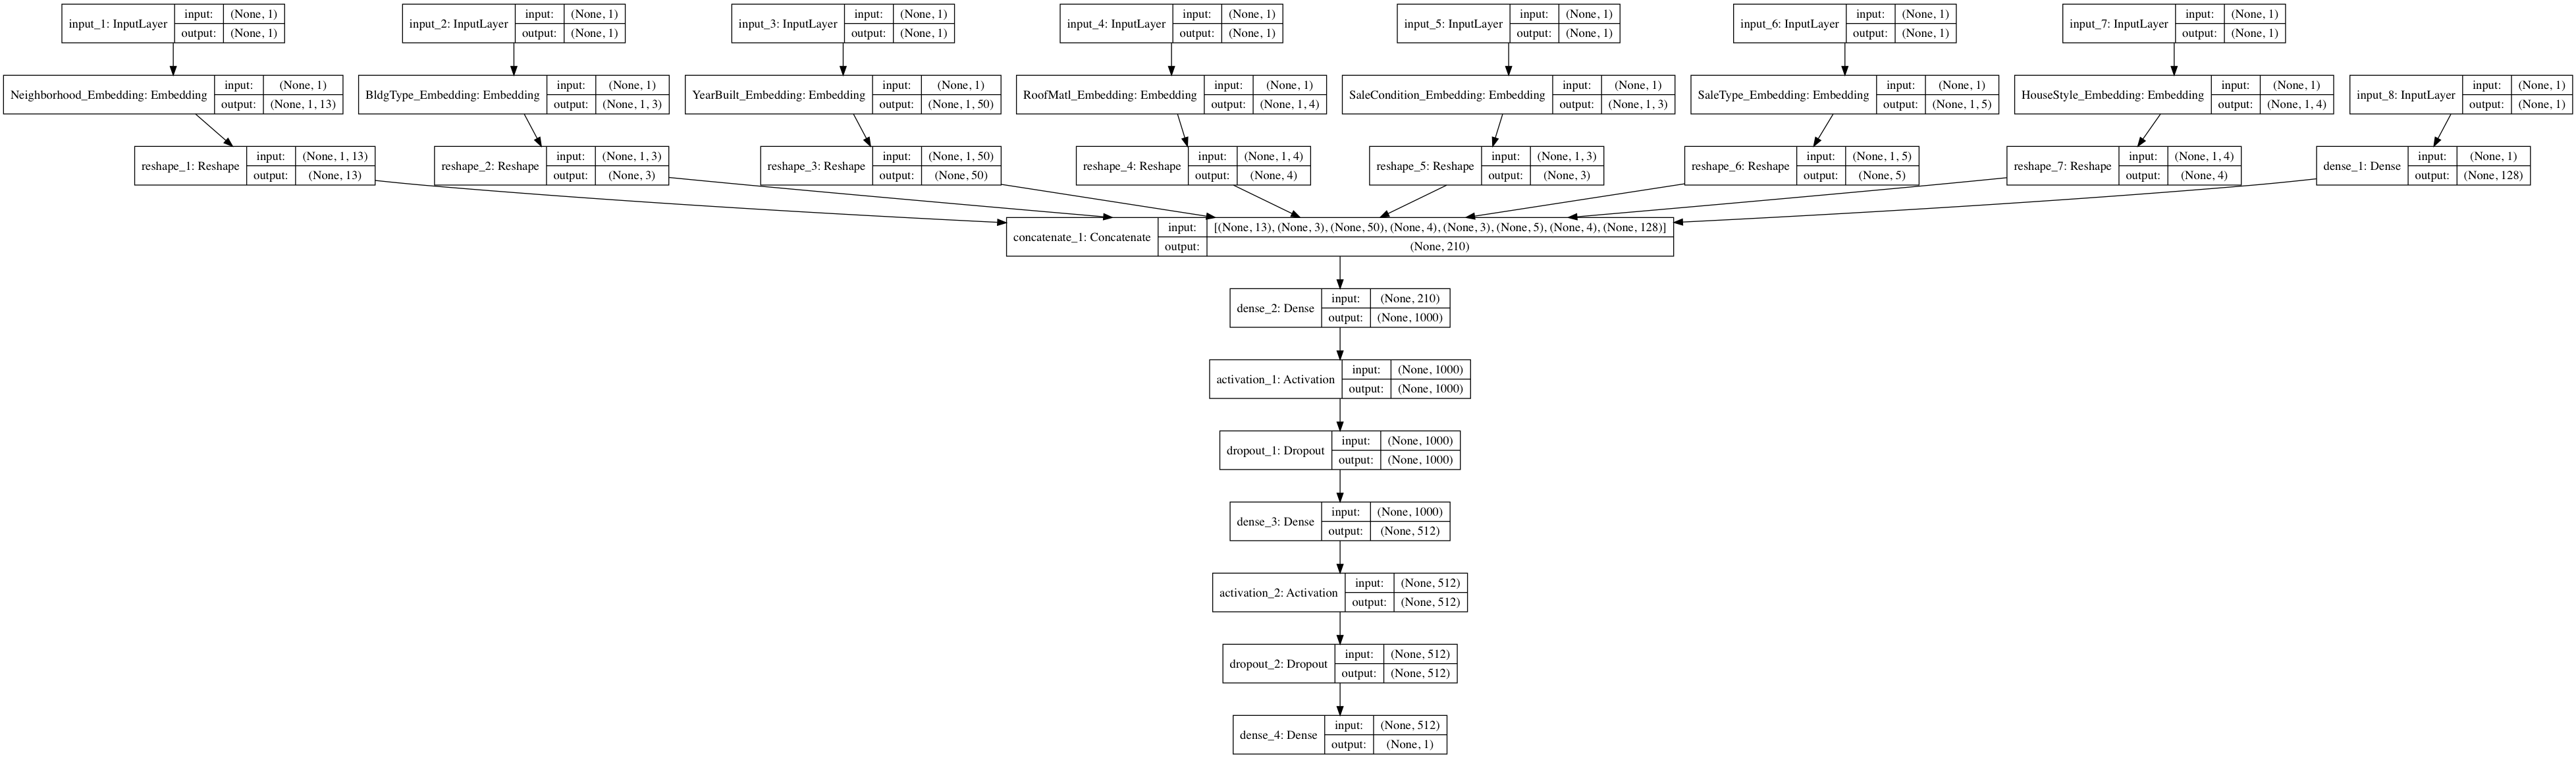

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

### *  ** Training**


In [19]:
X_train_list,X_val_list,X_test_list = preproc(X_train,X_val, X_test)

In [20]:
history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val) , epochs =  1000 , batch_size = 512, verbose= 2)

Train on 2000 samples, validate on 500 samples
Epoch 1/1000
 - 1s - loss: 1.1094 - mean_squared_error: 1.1094 - mean_absolute_percentage_error: 300.8905 - val_loss: 0.8694 - val_mean_squared_error: 0.8694 - val_mean_absolute_percentage_error: 273.3866
Epoch 2/1000
 - 0s - loss: 0.8420 - mean_squared_error: 0.8420 - mean_absolute_percentage_error: 256.9126 - val_loss: 0.7448 - val_mean_squared_error: 0.7448 - val_mean_absolute_percentage_error: 211.2060
Epoch 3/1000
 - 1s - loss: 0.7617 - mean_squared_error: 0.7617 - mean_absolute_percentage_error: 201.2317 - val_loss: 0.7306 - val_mean_squared_error: 0.7306 - val_mean_absolute_percentage_error: 163.0285
Epoch 4/1000
 - 1s - loss: 0.7309 - mean_squared_error: 0.7309 - mean_absolute_percentage_error: 162.7063 - val_loss: 0.7126 - val_mean_squared_error: 0.7126 - val_mean_absolute_percentage_error: 141.2770
Epoch 5/1000
 - 0s - loss: 0.6975 - mean_squared_error: 0.6975 - mean_absolute_percentage_error: 146.2286 - val_loss: 0.6919 - val_me

Epoch 41/1000
 - 0s - loss: 0.5738 - mean_squared_error: 0.5738 - mean_absolute_percentage_error: 104.0026 - val_loss: 0.6383 - val_mean_squared_error: 0.6383 - val_mean_absolute_percentage_error: 115.2538
Epoch 42/1000
 - 0s - loss: 0.5732 - mean_squared_error: 0.5732 - mean_absolute_percentage_error: 103.3374 - val_loss: 0.6378 - val_mean_squared_error: 0.6378 - val_mean_absolute_percentage_error: 114.7661
Epoch 43/1000
 - 0s - loss: 0.5719 - mean_squared_error: 0.5719 - mean_absolute_percentage_error: 104.0965 - val_loss: 0.6377 - val_mean_squared_error: 0.6377 - val_mean_absolute_percentage_error: 115.3850
Epoch 44/1000
 - 0s - loss: 0.5727 - mean_squared_error: 0.5727 - mean_absolute_percentage_error: 103.8663 - val_loss: 0.6373 - val_mean_squared_error: 0.6373 - val_mean_absolute_percentage_error: 114.9304
Epoch 45/1000
 - 0s - loss: 0.5719 - mean_squared_error: 0.5719 - mean_absolute_percentage_error: 102.1785 - val_loss: 0.6373 - val_mean_squared_error: 0.6373 - val_mean_absolu

Epoch 81/1000
 - 0s - loss: 0.5646 - mean_squared_error: 0.5646 - mean_absolute_percentage_error: 97.0029 - val_loss: 0.6350 - val_mean_squared_error: 0.6350 - val_mean_absolute_percentage_error: 118.5665
Epoch 82/1000
 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - mean_absolute_percentage_error: 99.0771 - val_loss: 0.6349 - val_mean_squared_error: 0.6349 - val_mean_absolute_percentage_error: 116.7776
Epoch 83/1000
 - 0s - loss: 0.5652 - mean_squared_error: 0.5652 - mean_absolute_percentage_error: 96.3167 - val_loss: 0.6340 - val_mean_squared_error: 0.6340 - val_mean_absolute_percentage_error: 116.8421
Epoch 84/1000
 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - mean_absolute_percentage_error: 98.4222 - val_loss: 0.6362 - val_mean_squared_error: 0.6362 - val_mean_absolute_percentage_error: 120.4958
Epoch 85/1000
 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - mean_absolute_percentage_error: 96.6089 - val_loss: 0.6359 - val_mean_squared_error: 0.6359 - val_mean_absolute_pe

Epoch 121/1000
 - 0s - loss: 0.5614 - mean_squared_error: 0.5614 - mean_absolute_percentage_error: 93.4241 - val_loss: 0.6330 - val_mean_squared_error: 0.6330 - val_mean_absolute_percentage_error: 114.4071
Epoch 122/1000
 - 0s - loss: 0.5609 - mean_squared_error: 0.5609 - mean_absolute_percentage_error: 91.9092 - val_loss: 0.6341 - val_mean_squared_error: 0.6341 - val_mean_absolute_percentage_error: 117.2935
Epoch 123/1000
 - 0s - loss: 0.5609 - mean_squared_error: 0.5609 - mean_absolute_percentage_error: 93.7234 - val_loss: 0.6332 - val_mean_squared_error: 0.6332 - val_mean_absolute_percentage_error: 116.2429
Epoch 124/1000
 - 0s - loss: 0.5610 - mean_squared_error: 0.5610 - mean_absolute_percentage_error: 92.5909 - val_loss: 0.6333 - val_mean_squared_error: 0.6333 - val_mean_absolute_percentage_error: 116.2273
Epoch 125/1000
 - 0s - loss: 0.5606 - mean_squared_error: 0.5606 - mean_absolute_percentage_error: 92.7318 - val_loss: 0.6328 - val_mean_squared_error: 0.6328 - val_mean_absolu

Epoch 161/1000
 - 0s - loss: 0.5594 - mean_squared_error: 0.5594 - mean_absolute_percentage_error: 91.5370 - val_loss: 0.6328 - val_mean_squared_error: 0.6328 - val_mean_absolute_percentage_error: 116.1568
Epoch 162/1000
 - 0s - loss: 0.5592 - mean_squared_error: 0.5592 - mean_absolute_percentage_error: 89.4893 - val_loss: 0.6339 - val_mean_squared_error: 0.6339 - val_mean_absolute_percentage_error: 118.5758
Epoch 163/1000
 - 0s - loss: 0.5593 - mean_squared_error: 0.5593 - mean_absolute_percentage_error: 90.6861 - val_loss: 0.6339 - val_mean_squared_error: 0.6339 - val_mean_absolute_percentage_error: 118.6764
Epoch 164/1000
 - 0s - loss: 0.5590 - mean_squared_error: 0.5590 - mean_absolute_percentage_error: 89.4289 - val_loss: 0.6340 - val_mean_squared_error: 0.6340 - val_mean_absolute_percentage_error: 117.0789
Epoch 165/1000
 - 1s - loss: 0.5594 - mean_squared_error: 0.5594 - mean_absolute_percentage_error: 90.5170 - val_loss: 0.6345 - val_mean_squared_error: 0.6345 - val_mean_absolu

Epoch 201/1000
 - 0s - loss: 0.5585 - mean_squared_error: 0.5585 - mean_absolute_percentage_error: 87.7233 - val_loss: 0.6345 - val_mean_squared_error: 0.6345 - val_mean_absolute_percentage_error: 119.3896
Epoch 202/1000
 - 0s - loss: 0.5586 - mean_squared_error: 0.5586 - mean_absolute_percentage_error: 87.9567 - val_loss: 0.6343 - val_mean_squared_error: 0.6343 - val_mean_absolute_percentage_error: 118.5845
Epoch 203/1000
 - 0s - loss: 0.5584 - mean_squared_error: 0.5584 - mean_absolute_percentage_error: 87.2733 - val_loss: 0.6345 - val_mean_squared_error: 0.6345 - val_mean_absolute_percentage_error: 118.9622
Epoch 204/1000
 - 0s - loss: 0.5585 - mean_squared_error: 0.5585 - mean_absolute_percentage_error: 89.0830 - val_loss: 0.6342 - val_mean_squared_error: 0.6342 - val_mean_absolute_percentage_error: 117.3667
Epoch 205/1000
 - 0s - loss: 0.5582 - mean_squared_error: 0.5582 - mean_absolute_percentage_error: 88.1804 - val_loss: 0.6343 - val_mean_squared_error: 0.6343 - val_mean_absolu

Epoch 241/1000
 - 0s - loss: 0.5579 - mean_squared_error: 0.5579 - mean_absolute_percentage_error: 88.0675 - val_loss: 0.6329 - val_mean_squared_error: 0.6329 - val_mean_absolute_percentage_error: 119.9900
Epoch 242/1000
 - 0s - loss: 0.5580 - mean_squared_error: 0.5580 - mean_absolute_percentage_error: 87.8265 - val_loss: 0.6326 - val_mean_squared_error: 0.6326 - val_mean_absolute_percentage_error: 118.4353
Epoch 243/1000
 - 0s - loss: 0.5578 - mean_squared_error: 0.5578 - mean_absolute_percentage_error: 86.7383 - val_loss: 0.6324 - val_mean_squared_error: 0.6324 - val_mean_absolute_percentage_error: 118.8323
Epoch 244/1000
 - 0s - loss: 0.5576 - mean_squared_error: 0.5576 - mean_absolute_percentage_error: 86.3140 - val_loss: 0.6325 - val_mean_squared_error: 0.6325 - val_mean_absolute_percentage_error: 117.5354
Epoch 245/1000
 - 0s - loss: 0.5578 - mean_squared_error: 0.5578 - mean_absolute_percentage_error: 86.7380 - val_loss: 0.6326 - val_mean_squared_error: 0.6326 - val_mean_absolu

Epoch 281/1000
 - 0s - loss: 0.5568 - mean_squared_error: 0.5568 - mean_absolute_percentage_error: 86.8869 - val_loss: 0.6412 - val_mean_squared_error: 0.6412 - val_mean_absolute_percentage_error: 120.2290
Epoch 282/1000
 - 0s - loss: 0.5567 - mean_squared_error: 0.5567 - mean_absolute_percentage_error: 89.3595 - val_loss: 0.6418 - val_mean_squared_error: 0.6418 - val_mean_absolute_percentage_error: 121.3644
Epoch 283/1000
 - 0s - loss: 0.5568 - mean_squared_error: 0.5568 - mean_absolute_percentage_error: 87.9535 - val_loss: 0.6420 - val_mean_squared_error: 0.6420 - val_mean_absolute_percentage_error: 118.0273
Epoch 284/1000
 - 0s - loss: 0.5563 - mean_squared_error: 0.5563 - mean_absolute_percentage_error: 87.6296 - val_loss: 0.6404 - val_mean_squared_error: 0.6404 - val_mean_absolute_percentage_error: 118.4268
Epoch 285/1000
 - 0s - loss: 0.5565 - mean_squared_error: 0.5565 - mean_absolute_percentage_error: 87.9981 - val_loss: 0.6402 - val_mean_squared_error: 0.6402 - val_mean_absolu

Epoch 321/1000
 - 0s - loss: 0.5558 - mean_squared_error: 0.5558 - mean_absolute_percentage_error: 86.3307 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - val_mean_absolute_percentage_error: 121.0483
Epoch 322/1000
 - 0s - loss: 0.5557 - mean_squared_error: 0.5557 - mean_absolute_percentage_error: 86.0507 - val_loss: 0.6416 - val_mean_squared_error: 0.6416 - val_mean_absolute_percentage_error: 119.4728
Epoch 323/1000
 - 0s - loss: 0.5556 - mean_squared_error: 0.5556 - mean_absolute_percentage_error: 84.9062 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - val_mean_absolute_percentage_error: 117.9825
Epoch 324/1000
 - 0s - loss: 0.5556 - mean_squared_error: 0.5556 - mean_absolute_percentage_error: 86.0277 - val_loss: 0.6407 - val_mean_squared_error: 0.6407 - val_mean_absolute_percentage_error: 120.2373
Epoch 325/1000
 - 0s - loss: 0.5556 - mean_squared_error: 0.5556 - mean_absolute_percentage_error: 85.2611 - val_loss: 0.6418 - val_mean_squared_error: 0.6418 - val_mean_absolu

Epoch 361/1000
 - 0s - loss: 0.5552 - mean_squared_error: 0.5552 - mean_absolute_percentage_error: 83.9421 - val_loss: 0.6404 - val_mean_squared_error: 0.6404 - val_mean_absolute_percentage_error: 119.3269
Epoch 362/1000
 - 0s - loss: 0.5552 - mean_squared_error: 0.5552 - mean_absolute_percentage_error: 84.2701 - val_loss: 0.6417 - val_mean_squared_error: 0.6417 - val_mean_absolute_percentage_error: 119.5421
Epoch 363/1000
 - 0s - loss: 0.5553 - mean_squared_error: 0.5553 - mean_absolute_percentage_error: 84.8396 - val_loss: 0.6411 - val_mean_squared_error: 0.6411 - val_mean_absolute_percentage_error: 119.6045
Epoch 364/1000
 - 0s - loss: 0.5555 - mean_squared_error: 0.5555 - mean_absolute_percentage_error: 84.5639 - val_loss: 0.6423 - val_mean_squared_error: 0.6423 - val_mean_absolute_percentage_error: 120.0908
Epoch 365/1000
 - 0s - loss: 0.5551 - mean_squared_error: 0.5551 - mean_absolute_percentage_error: 83.3669 - val_loss: 0.6428 - val_mean_squared_error: 0.6428 - val_mean_absolu

Epoch 401/1000
 - 0s - loss: 0.5550 - mean_squared_error: 0.5550 - mean_absolute_percentage_error: 85.9637 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - val_mean_absolute_percentage_error: 123.2167
Epoch 402/1000
 - 0s - loss: 0.5552 - mean_squared_error: 0.5552 - mean_absolute_percentage_error: 84.1759 - val_loss: 0.6420 - val_mean_squared_error: 0.6420 - val_mean_absolute_percentage_error: 123.8966
Epoch 403/1000
 - 0s - loss: 0.5551 - mean_squared_error: 0.5551 - mean_absolute_percentage_error: 84.3824 - val_loss: 0.6403 - val_mean_squared_error: 0.6403 - val_mean_absolute_percentage_error: 121.4330
Epoch 404/1000
 - 0s - loss: 0.5550 - mean_squared_error: 0.5550 - mean_absolute_percentage_error: 85.4504 - val_loss: 0.6421 - val_mean_squared_error: 0.6421 - val_mean_absolute_percentage_error: 122.3811
Epoch 405/1000
 - 0s - loss: 0.5549 - mean_squared_error: 0.5549 - mean_absolute_percentage_error: 84.1498 - val_loss: 0.6411 - val_mean_squared_error: 0.6411 - val_mean_absolu

Epoch 441/1000
 - 0s - loss: 0.5547 - mean_squared_error: 0.5547 - mean_absolute_percentage_error: 82.5290 - val_loss: 0.6416 - val_mean_squared_error: 0.6416 - val_mean_absolute_percentage_error: 123.1712
Epoch 442/1000
 - 0s - loss: 0.5548 - mean_squared_error: 0.5548 - mean_absolute_percentage_error: 83.2134 - val_loss: 0.6430 - val_mean_squared_error: 0.6430 - val_mean_absolute_percentage_error: 123.4500
Epoch 443/1000
 - 0s - loss: 0.5546 - mean_squared_error: 0.5546 - mean_absolute_percentage_error: 83.7800 - val_loss: 0.6434 - val_mean_squared_error: 0.6434 - val_mean_absolute_percentage_error: 123.4379
Epoch 444/1000
 - 0s - loss: 0.5546 - mean_squared_error: 0.5546 - mean_absolute_percentage_error: 83.0803 - val_loss: 0.6421 - val_mean_squared_error: 0.6421 - val_mean_absolute_percentage_error: 122.8003
Epoch 445/1000
 - 0s - loss: 0.5547 - mean_squared_error: 0.5547 - mean_absolute_percentage_error: 83.5272 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - val_mean_absolu

Epoch 481/1000
 - 0s - loss: 0.5542 - mean_squared_error: 0.5542 - mean_absolute_percentage_error: 82.9555 - val_loss: 0.6421 - val_mean_squared_error: 0.6421 - val_mean_absolute_percentage_error: 122.0208
Epoch 482/1000
 - 0s - loss: 0.5545 - mean_squared_error: 0.5545 - mean_absolute_percentage_error: 82.5408 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - val_mean_absolute_percentage_error: 122.1362
Epoch 483/1000
 - 0s - loss: 0.5545 - mean_squared_error: 0.5545 - mean_absolute_percentage_error: 82.7054 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - val_mean_absolute_percentage_error: 124.1010
Epoch 484/1000
 - 0s - loss: 0.5545 - mean_squared_error: 0.5545 - mean_absolute_percentage_error: 82.2449 - val_loss: 0.6422 - val_mean_squared_error: 0.6422 - val_mean_absolute_percentage_error: 122.4303
Epoch 485/1000
 - 0s - loss: 0.5542 - mean_squared_error: 0.5542 - mean_absolute_percentage_error: 82.6338 - val_loss: 0.6420 - val_mean_squared_error: 0.6420 - val_mean_absolu

Epoch 521/1000
 - 0s - loss: 0.5546 - mean_squared_error: 0.5546 - mean_absolute_percentage_error: 83.4262 - val_loss: 0.6460 - val_mean_squared_error: 0.6460 - val_mean_absolute_percentage_error: 122.7247
Epoch 522/1000
 - 0s - loss: 0.5543 - mean_squared_error: 0.5543 - mean_absolute_percentage_error: 81.5114 - val_loss: 0.6457 - val_mean_squared_error: 0.6457 - val_mean_absolute_percentage_error: 123.7898
Epoch 523/1000
 - 0s - loss: 0.5546 - mean_squared_error: 0.5546 - mean_absolute_percentage_error: 83.1093 - val_loss: 0.6455 - val_mean_squared_error: 0.6455 - val_mean_absolute_percentage_error: 121.6706
Epoch 524/1000
 - 0s - loss: 0.5544 - mean_squared_error: 0.5544 - mean_absolute_percentage_error: 81.5666 - val_loss: 0.6459 - val_mean_squared_error: 0.6459 - val_mean_absolute_percentage_error: 120.6943
Epoch 525/1000
 - 0s - loss: 0.5545 - mean_squared_error: 0.5545 - mean_absolute_percentage_error: 82.8941 - val_loss: 0.6459 - val_mean_squared_error: 0.6459 - val_mean_absolu

Epoch 561/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 81.3124 - val_loss: 0.6417 - val_mean_squared_error: 0.6417 - val_mean_absolute_percentage_error: 121.7505
Epoch 562/1000
 - 0s - loss: 0.5543 - mean_squared_error: 0.5543 - mean_absolute_percentage_error: 81.9207 - val_loss: 0.6407 - val_mean_squared_error: 0.6407 - val_mean_absolute_percentage_error: 123.3716
Epoch 563/1000
 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - mean_absolute_percentage_error: 82.5562 - val_loss: 0.6414 - val_mean_squared_error: 0.6414 - val_mean_absolute_percentage_error: 121.5235
Epoch 564/1000
 - 0s - loss: 0.5543 - mean_squared_error: 0.5543 - mean_absolute_percentage_error: 80.3006 - val_loss: 0.6418 - val_mean_squared_error: 0.6418 - val_mean_absolute_percentage_error: 121.6549
Epoch 565/1000
 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - mean_absolute_percentage_error: 80.9404 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - val_mean_absolu

Epoch 601/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 79.6240 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - val_mean_absolute_percentage_error: 122.6580
Epoch 602/1000
 - 0s - loss: 0.5542 - mean_squared_error: 0.5542 - mean_absolute_percentage_error: 82.4846 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - val_mean_absolute_percentage_error: 122.9094
Epoch 603/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 80.4239 - val_loss: 0.6422 - val_mean_squared_error: 0.6422 - val_mean_absolute_percentage_error: 121.0612
Epoch 604/1000
 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - mean_absolute_percentage_error: 80.3672 - val_loss: 0.6415 - val_mean_squared_error: 0.6415 - val_mean_absolute_percentage_error: 121.2855
Epoch 605/1000
 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - mean_absolute_percentage_error: 81.6699 - val_loss: 0.6414 - val_mean_squared_error: 0.6414 - val_mean_absolu

Epoch 641/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 79.8039 - val_loss: 0.6433 - val_mean_squared_error: 0.6433 - val_mean_absolute_percentage_error: 122.7274
Epoch 642/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 80.4541 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - val_mean_absolute_percentage_error: 121.7025
Epoch 643/1000
 - 0s - loss: 0.5543 - mean_squared_error: 0.5543 - mean_absolute_percentage_error: 80.5279 - val_loss: 0.6443 - val_mean_squared_error: 0.6443 - val_mean_absolute_percentage_error: 121.9040
Epoch 644/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 81.2449 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - val_mean_absolute_percentage_error: 122.4077
Epoch 645/1000
 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - mean_absolute_percentage_error: 80.7426 - val_loss: 0.6449 - val_mean_squared_error: 0.6449 - val_mean_absolu

Epoch 681/1000
 - 1s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 79.3822 - val_loss: 0.6428 - val_mean_squared_error: 0.6428 - val_mean_absolute_percentage_error: 121.7253
Epoch 682/1000
 - 1s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 79.6796 - val_loss: 0.6433 - val_mean_squared_error: 0.6433 - val_mean_absolute_percentage_error: 121.8686
Epoch 683/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 79.5442 - val_loss: 0.6443 - val_mean_squared_error: 0.6443 - val_mean_absolute_percentage_error: 122.3180
Epoch 684/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 79.6125 - val_loss: 0.6450 - val_mean_squared_error: 0.6450 - val_mean_absolute_percentage_error: 121.2574
Epoch 685/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 79.4883 - val_loss: 0.6447 - val_mean_squared_error: 0.6447 - val_mean_absolu

Epoch 721/1000
 - 0s - loss: 0.5541 - mean_squared_error: 0.5541 - mean_absolute_percentage_error: 80.0079 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - val_mean_absolute_percentage_error: 122.5515
Epoch 722/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 80.7305 - val_loss: 0.6432 - val_mean_squared_error: 0.6432 - val_mean_absolute_percentage_error: 123.4976
Epoch 723/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 79.9899 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - val_mean_absolute_percentage_error: 122.2041
Epoch 724/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 80.3194 - val_loss: 0.6438 - val_mean_squared_error: 0.6438 - val_mean_absolute_percentage_error: 120.3826
Epoch 725/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 80.0973 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - val_mean_absolu

Epoch 761/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 79.8750 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - val_mean_absolute_percentage_error: 119.8978
Epoch 762/1000
 - 1s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 80.1418 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - val_mean_absolute_percentage_error: 124.1224
Epoch 763/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 79.9115 - val_loss: 0.6457 - val_mean_squared_error: 0.6457 - val_mean_absolute_percentage_error: 124.4165
Epoch 764/1000
 - 1s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 80.0311 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - val_mean_absolute_percentage_error: 121.7275
Epoch 765/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 78.8442 - val_loss: 0.6459 - val_mean_squared_error: 0.6459 - val_mean_absolu

Epoch 801/1000
 - 0s - loss: 0.5546 - mean_squared_error: 0.5546 - mean_absolute_percentage_error: 80.4417 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - val_mean_absolute_percentage_error: 119.0573
Epoch 802/1000
 - 0s - loss: 0.5543 - mean_squared_error: 0.5543 - mean_absolute_percentage_error: 79.3560 - val_loss: 0.6456 - val_mean_squared_error: 0.6456 - val_mean_absolute_percentage_error: 119.7934
Epoch 803/1000
 - 0s - loss: 0.5549 - mean_squared_error: 0.5549 - mean_absolute_percentage_error: 79.6003 - val_loss: 0.6444 - val_mean_squared_error: 0.6444 - val_mean_absolute_percentage_error: 123.9369
Epoch 804/1000
 - 1s - loss: 0.5546 - mean_squared_error: 0.5546 - mean_absolute_percentage_error: 81.0768 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - val_mean_absolute_percentage_error: 121.4028
Epoch 805/1000
 - 0s - loss: 0.5544 - mean_squared_error: 0.5544 - mean_absolute_percentage_error: 79.0933 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - val_mean_absolu

Epoch 841/1000
 - 0s - loss: 0.5537 - mean_squared_error: 0.5537 - mean_absolute_percentage_error: 78.7640 - val_loss: 0.6445 - val_mean_squared_error: 0.6445 - val_mean_absolute_percentage_error: 121.9564
Epoch 842/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 78.8323 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - val_mean_absolute_percentage_error: 120.4106
Epoch 843/1000
 - 0s - loss: 0.5539 - mean_squared_error: 0.5539 - mean_absolute_percentage_error: 79.6419 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - val_mean_absolute_percentage_error: 122.1586
Epoch 844/1000
 - 0s - loss: 0.5537 - mean_squared_error: 0.5537 - mean_absolute_percentage_error: 78.5590 - val_loss: 0.6449 - val_mean_squared_error: 0.6449 - val_mean_absolute_percentage_error: 122.1728
Epoch 845/1000
 - 0s - loss: 0.5536 - mean_squared_error: 0.5536 - mean_absolute_percentage_error: 78.8829 - val_loss: 0.6449 - val_mean_squared_error: 0.6449 - val_mean_absolu

Epoch 881/1000
 - 0s - loss: 0.5540 - mean_squared_error: 0.5540 - mean_absolute_percentage_error: 82.1819 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - val_mean_absolute_percentage_error: 121.0017
Epoch 882/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 79.6619 - val_loss: 0.6454 - val_mean_squared_error: 0.6454 - val_mean_absolute_percentage_error: 123.0986
Epoch 883/1000
 - 0s - loss: 0.5536 - mean_squared_error: 0.5536 - mean_absolute_percentage_error: 79.0418 - val_loss: 0.6450 - val_mean_squared_error: 0.6450 - val_mean_absolute_percentage_error: 120.9976
Epoch 884/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 79.2370 - val_loss: 0.6454 - val_mean_squared_error: 0.6454 - val_mean_absolute_percentage_error: 120.7483
Epoch 885/1000
 - 1s - loss: 0.5536 - mean_squared_error: 0.5536 - mean_absolute_percentage_error: 77.6488 - val_loss: 0.6450 - val_mean_squared_error: 0.6450 - val_mean_absolu

Epoch 921/1000
 - 1s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 79.4466 - val_loss: 0.6447 - val_mean_squared_error: 0.6447 - val_mean_absolute_percentage_error: 121.2893
Epoch 922/1000
 - 0s - loss: 0.5536 - mean_squared_error: 0.5536 - mean_absolute_percentage_error: 78.5352 - val_loss: 0.6457 - val_mean_squared_error: 0.6457 - val_mean_absolute_percentage_error: 121.8551
Epoch 923/1000
 - 0s - loss: 0.5537 - mean_squared_error: 0.5537 - mean_absolute_percentage_error: 80.5198 - val_loss: 0.6466 - val_mean_squared_error: 0.6466 - val_mean_absolute_percentage_error: 122.6791
Epoch 924/1000
 - 0s - loss: 0.5538 - mean_squared_error: 0.5538 - mean_absolute_percentage_error: 80.0395 - val_loss: 0.6460 - val_mean_squared_error: 0.6460 - val_mean_absolute_percentage_error: 120.5504
Epoch 925/1000
 - 0s - loss: 0.5537 - mean_squared_error: 0.5537 - mean_absolute_percentage_error: 80.7587 - val_loss: 0.6447 - val_mean_squared_error: 0.6447 - val_mean_absolu

Epoch 961/1000
 - 1s - loss: 0.5551 - mean_squared_error: 0.5551 - mean_absolute_percentage_error: 80.4089 - val_loss: 0.6468 - val_mean_squared_error: 0.6468 - val_mean_absolute_percentage_error: 124.1005
Epoch 962/1000
 - 0s - loss: 0.5550 - mean_squared_error: 0.5550 - mean_absolute_percentage_error: 82.1500 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - val_mean_absolute_percentage_error: 123.4751
Epoch 963/1000
 - 0s - loss: 0.5550 - mean_squared_error: 0.5550 - mean_absolute_percentage_error: 81.4845 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - val_mean_absolute_percentage_error: 119.3414
Epoch 964/1000
 - 0s - loss: 0.5549 - mean_squared_error: 0.5549 - mean_absolute_percentage_error: 79.9776 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - val_mean_absolute_percentage_error: 120.3623
Epoch 965/1000
 - 0s - loss: 0.5552 - mean_squared_error: 0.5552 - mean_absolute_percentage_error: 81.8392 - val_loss: 0.6446 - val_mean_squared_error: 0.6446 - val_mean_absolu

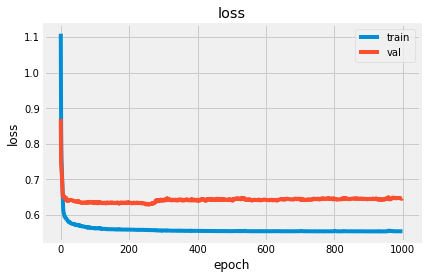

In [21]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

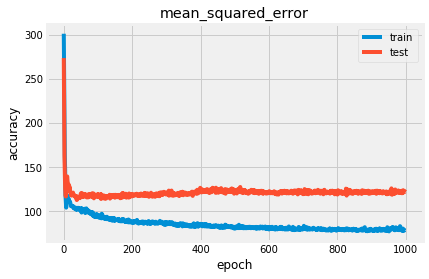

In [22]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_squared_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()